<center><img src="images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 3, Lab 2: Using a CNN for Basic Image Operations

This notebook will show you how to perform basic image operations on a dataset. Then, you will build a convolutional neural network (CNN) by using built-in CNN architectures in [PyTorch](https://pytorch.org/docs/stable/index.html) to train a multiclass classification model on a real-world dataset. You will also examine the effect of adding layers to a neural network.

You will learn how to do the following:

- Import data.
- Apply padding and stride to data.
- Create a neural network.
- Add layers to a neural network.
- Evaluate the performance of a neural network.

----

You will be presented with a challenge at the end of this lab:

| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/> |
| --- |
| <p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |

Note: Images in this lab were reproduced from work created and shared by D2L, https://d2l.ai, and used according to terms described in the Creative Commons 4.0 Attribution License.


---
## What is a CNN?

Before you build a CNN, let's briefly discuss what a CNN is and how it works. A CNN is a type of neural network that is commonly used for image classification, object detection, and other computer vision (CV) tasks. A CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers.

Convolutional layers are the heart of a CNN. They use a set of learnable filters to scan the input image and extract features. Pooling layers then reduce the size of the feature maps that the convolutional layers produce. Finally, the fully connected layers use these features to make predictions about the input image.


## Index

- [Toy example](#Toy-example)
- [Real-world example: CIFAR-10](#Real-world-example:-CIFAR-10)

---
## Toy example

First, look at a sample tensor that you can use as a toy example to understand the concepts of convolution and pooling. 
Note: The "toy example" here is a simplified and small-scale representation of basic image operations. It's used for initial exploration based on simple data

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.utils.data.sampler import SubsetRandomSampler

Matplotlib is building the font cache; this may take a moment.


### Convolution 2D

The built-in CNN classes in PyTorch have a variety of convolutional layers, such as the following:

```python
nn.Conv1d()
nn.Conv2d()
nn.Conv3d()
```

For more information, see [Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers) on the torch.nn page in the PyTorch documentation.

To improve results, apply padding and stride. Recall that padding adds rows or columns around the input. In the following example, padding of 1 is added to each side:

![Padding.](https://d2l.ai/_images/conv-pad.svg)


Stride refers to the number of units that the kernel shifts in each direction per step. In the following example, a stride of (2,3) is used:

![Stride.](https://d2l.ai/_images/conv-stride.svg)

Start by creating a sample tensor with shape (3, 3), kernel size of 2, padding size of 1, and stride size of (2, 3).

In [3]:
# Initialize a tensor
X = torch.rand(size=(3, 3))

# Create a 2D convolution
conv2d = nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=2, padding=1, stride=(2, 3)
)

### Computing the shape

Now you need to determine what the resulting shape of the tensor is after the updates to the `Conv2d` class were applied.

The output shape of `Conv2d()` should be the following:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor \\
 & = \lfloor(3 - 2 + 2*1 + 2) / 2\rfloor \times \lfloor(3 - 2 + 2*1 + 3) / 3\rfloor \\
 & = (2, 2)
\end{align}

You can validate this in code. To check the output of the convolution layers, define the `comp_conv2d` function as forward propagation.

In [4]:
def comp_conv2d(conv2d, X):
    # Reshaping with (1, 1) specifies batch size and number of channels
    # Batch of 1 image is processed, and the input image is assumed to be a grayscale image (1 channel)
    X = X.reshape((1, 1) + X.shape)
    print("Input shape:", X.shape)
    Y = conv2d(X)
    print("Output shape:", Y.shape)
    # Exclude the first two dimensions that aren't of interest:
    # examples and channels
    return Y.reshape(Y.shape[2:])

Now that you created this function, you can use it to verify the output shape of the Conv2D layer.

In [5]:
comp_conv2d(conv2d, X).shape

Input shape: torch.Size([1, 1, 3, 3])
Output shape: torch.Size([1, 1, 2, 2])


torch.Size([2, 2])

### Pooling

Recall that max pooling returns the maximal value in the pooling window, while average pooling returns the mean.

![Pooling.](https://d2l.ai/_images/pooling.svg)


You can also import a built-in pooling layer from PyTorch with padding and stride. Some examples are `MaxPool2d()` and `AvgPool1d()`.

For more information, see [Pooling Layers](https://pytorch.org/docs/stable/nn.html#pooling-layers) on the torch.nn page in the PyTorch documentation.

In [6]:
# Create a new sample tensor with 4 rows and 4 columns
# The values inside the tensor range from 0 to 15
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
print(X)

# Apply the pooling
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
print(pool2d(X))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


---
## Real-world example: CIFAR-10

Now that you have explored the key concepts of convolution, you can use what you have learned to build a simple CNN to process some real-world data. To do this, you will load the dataset, design the network, and finally evaluate the network's performance.

You will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has the following classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The images in the CIFAR-10 dataset are of size 3x32x32, which means that they are 3-channel color images that are 32x32 pixels in size.

The following image provides a sample of images from each class in the dataset:

![CIFAR10 Examples.](https://pytorch.org/tutorials/_images/cifar10.png)


---
## Loading the dataset

To load the dataset, you need to prepare the image data a bit by using `transfom` functions.

First, convert the image tensor of shape (C x H x W) in the range [0, 255] to a `float32` torch tensor of shape (C x H x W) in the range [0, 1] by using the `ToTensor` class. Then, normalize a tensor of shape (C x H x W) with its mean and standard deviation by using the `Normalize` function.

In [7]:
transformation = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))]
)

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transformation
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transformation
)

100%|██████████| 170498071/170498071 [00:04<00:00, 42045959.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


It's helpful to visualize what the dataset looks like. To do this, define a `show_images` function, and then use the function to display sample images.

In [9]:
# Create a function to load images and display them
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

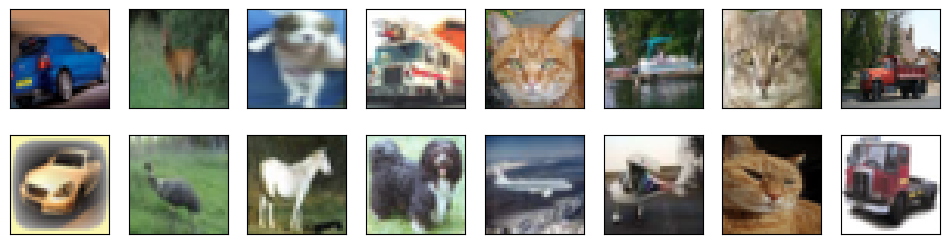

In [10]:
# Use DataLoader to get sample images
sample = DataLoader(train_dataset, batch_size=2 * 8, shuffle=True)

# Use the loaded images with the show_images function to display them
for data, label in sample:
    show_images(data, 2, 8)
    break

In practice, reading in or plotting images can be a significant performance bottleneck. To facilitate the processing of reading images from the datasets, use a PyTorch `DataLoader`. The `DataLoader` reads a minibatch of data with size `batch_size` each time.

Before building the convolutional network, you need to set up the `DataLoader` and split the training dataset into train and validation sets.

In [11]:
# Define the batch size for the minibatches
batch_size = 16

# Define the percentage of the dataset that you want in the validation set
valid_size = 0.2

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

# Split the dataset
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Load the training data
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
)

# Load the validation data
valid_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=valid_sampler,
)

# Create minibatches
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---
## Designing the network

Now that you have seen the data, it's time to design a CNN.

First, initialize a `Sequential` block. In PyTorch, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` block passes it through the first layer, in turn passing the output as the second layer's input and so forth.

You will build a neural network with a 2D convolutional layer, `Conv2D(in_channels=3, out_channels=16, kernel_size=5)`. This will be followed by a 2D max pooling layer, `MaxPool2d(kernel_size=2, stride=2)`; a fully connected (or `Dense`) layer; and a final output `Dense` layer with output classes 10 (because CIFAR-10 contains 10 different classes). Use `ReLU` as the activation function between layers.

To get the correct dimensions for the final dense layer, consider what the various transformations have done to the input size of the image. You might want to create a helper function to calculate the output shape; the final result should be `nn.Linear(14 * 14 * 16, 32)`.

In [12]:
# Create helper function to calculate the image size after applying layers
def maxpool(w, k, p=0, d=1, s=None):
    return ((w + 2 * p - d * (k - 1) - 1) / s) + 1


# Create helper function to calculate the image size after applying layers
def conv2d(w, k, p=0, d=1, s=1):
    return ((w - k + 2 * p) / s) + 1


maxpool(w=conv2d(32, 5), k=2, s=2)

14.0

In [13]:
# Use GPU resource, if available; otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the number of output classes
out_classes = 10

# Design the network
net = nn.Sequential(
    # Convolutional layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
    nn.ReLU(),
    # Max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    # The flatten layer collapses all axes,
    # except the first one, into one axis.
    nn.Flatten(),
    # Fully connected or dense Layer
    nn.Linear(14 * 14 * 16, 32),
    nn.ReLU(),
    # Output layer
    nn.Linear(32, out_classes),
).to(device)

The network is almost ready to be trained. The last thing to do before training is to set the number of epochs to train, the learning rate of optimization algorithms, and the loss function. Because this problem is a multiclass classification task, `CrossEntropyLoss` is the correct loss function to use.

In [14]:
epochs = 25
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

To calculate the accuracy easily, define a function, `calculate_accuracy(output, label)`, that can be called for each batch of data. The function uses the network's outputs and the corresponding labels to calculate the accuracy.

In [15]:
def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network.
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor"""

    return (output.argmax(axis=1) == label.float()).float().mean()

To get the neural network to optimize its weights, instantiate by using `optim.<Optimizer>`. This defines the parameters to optimize over (obtainable from the neural network by using `net.parameters()`) and the hyperparameters that the optimization algorithm requires. After you do that, it's time to train!

In [16]:
optimizer = SGD(net.parameters(), lr=learning_rate)

for epoch in range(epochs):
    net = net.to(device)

    train_loss, val_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0

    # Training loop
    # This loop trains the neural network (weights are updated)
    net.train()  # Activate training mode
    for data, label in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        label = label.to(device)
        # Make forward pass
        output = net(data)
        # Calculate loss
        loss = criterion(output, label)
        # Make backward pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        # Update weights
        optimizer.step()

    # Validation loop
    # This loop tests the trained network on the validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    net.eval()  # Activate evaluation mode
    with torch.no_grad():
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = net(data)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()

    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    print(
        "Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f"
        % (epoch + 1, train_loss, train_acc, val_loss, valid_acc)
    )

Epoch 1: train loss 1.930, train acc 0.292, val loss 1.717, val acc 0.389
Epoch 2: train loss 1.540, train acc 0.448, val loss 1.512, val acc 0.463
Epoch 3: train loss 1.389, train acc 0.502, val loss 1.353, val acc 0.509
Epoch 4: train loss 1.311, train acc 0.534, val loss 1.344, val acc 0.518
Epoch 5: train loss 1.257, train acc 0.555, val loss 1.243, val acc 0.558
Epoch 6: train loss 1.206, train acc 0.575, val loss 1.241, val acc 0.559
Epoch 7: train loss 1.162, train acc 0.589, val loss 1.198, val acc 0.575
Epoch 8: train loss 1.119, train acc 0.607, val loss 1.179, val acc 0.580
Epoch 9: train loss 1.081, train acc 0.620, val loss 1.175, val acc 0.583
Epoch 10: train loss 1.044, train acc 0.636, val loss 1.133, val acc 0.602
Epoch 11: train loss 1.011, train acc 0.647, val loss 1.134, val acc 0.603
Epoch 12: train loss 0.977, train acc 0.660, val loss 1.160, val acc 0.599
Epoch 13: train loss 0.951, train acc 0.670, val loss 1.128, val acc 0.611
Epoch 14: train loss 0.922, train 

Notice that the training loss and accuracy continue to improve, while the validation loss and accuracy are mostly fluctuating. This is a signal of overfitting.

---
## Evaluating the network

Now that you have trained the model, you can test its accuracy.

In [17]:
test_acc = 0.0

# Activate evaluation mode
net.eval()  

# Calculate the test accuracy
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        test_acc += calculate_accuracy(output, label).item()

# Calculate the average test accuracy
test_acc = test_acc / len(test_loader)

print("Test accuracy: %.3f" % test_acc)

Test accuracy: 0.589


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <img style="float: center;" src="images/challenge.png" alt="Challenge" width="100" />
    <p style="text-align: center; margin: auto;">Modify the neural network to create an <code>updated_net</code> that includes a second <code>Conv2d(in_channels=3, out_channels=16, kernel_size=5)</code> followed by a <code>MaxPool2d(kernel_size=2, stride=2)</code> layer. Continue to use <code>ReLU</code> as the activation function.</p><br>
    <p style="text-align: center; margin: auto;">Ensure that you update the dimensions in the dense layer to account for the additional convolution and pooling.</p><br>
    <p style="text-align: center; margin: auto;">You will also need to update the optimizer: <code>updated_optimizer = SGD(updated_net.parameters(), lr=learning_rate)</code>.</p><br>
    <p style="text-align: center; margin: auto;">Retrain the network, and evaluate on the test data. Has the performance improved?</p><br>
</div>

In [ ]:
############### CODE HERE ###############

# Define the updated network architecture
updated_net = nn.Sequential(
    # First Convolutional layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Second Convolutional layer
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten layer
    nn.Flatten(),
    # Fully connected layers
    nn.Linear(16 * 5 * 5, 120),  # Update the input size based on the output size from the previous layer
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, out_classes),  # Output layer
).to(device)

# Define the updated optimizer
updated_optimizer = SGD(updated_net.parameters(), lr=learning_rate)

# Retrain the network
for epoch in range(epochs):
    updated_net = updated_net.to(device)

    train_loss, val_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0

    # Training loop
    updated_net.train()
    for data, label in train_loader:
        updated_optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = updated_net(data)
        loss = criterion(output, label)
        loss.backward()
        updated_optimizer.step()
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()

    # Validation loop
    updated_net.eval()
    with torch.no_grad():
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            output = updated_net(data)
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    print(
        "Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f"
        % (epoch + 1, train_loss, train_acc, val_loss, valid_acc)
    )

# Evaluate on the test data
test_acc = 0.0
updated_net.eval()
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        output = updated_net(data)
        test_acc += calculate_accuracy(output, label).item()

test_acc = test_acc / len(test_loader)
print("Test accuracy with updated network: %.3f" % test_acc)


############## END OF CODE ##############

Epoch 1: train loss 2.184, train acc 0.175, val loss 1.961, val acc 0.272
Epoch 2: train loss 1.813, train acc 0.341, val loss 1.714, val acc 0.388
Epoch 3: train loss 1.567, train acc 0.433, val loss 1.465, val acc 0.466
Epoch 4: train loss 1.457, train acc 0.473, val loss 1.407, val acc 0.495
Epoch 5: train loss 1.384, train acc 0.502, val loss 1.358, val acc 0.508
Epoch 6: train loss 1.318, train acc 0.527, val loss 1.313, val acc 0.523
Epoch 7: train loss 1.263, train acc 0.550, val loss 1.293, val acc 0.537
Epoch 8: train loss 1.207, train acc 0.570, val loss 1.191, val acc 0.575
Epoch 9: train loss 1.153, train acc 0.590, val loss 1.219, val acc 0.574
Epoch 10: train loss 1.108, train acc 0.607, val loss 1.131, val acc 0.600
Epoch 11: train loss 1.064, train acc 0.622, val loss 1.193, val acc 0.584
Epoch 12: train loss 1.023, train acc 0.638, val loss 1.083, val acc 0.625
Epoch 13: train loss 0.984, train acc 0.651, val loss 1.073, val acc 0.626
Epoch 14: train loss 0.950, train 

----
## Conclusion

In this notebook, you practiced building a CNN. You learned that making the neural network more sophisticated by adding layers doesn't necessarily improve the performance. This tells you that a different type of neural network might be better suited to solve the image classification task.

--- 
## Next lab
In the next lab, you will continue to learn about CNNs by using PyTorch to process a real-world dataset.